# Content <-> audience

In [1]:
import pandas as pd
import warnings

from itertools import product
from tqdm import tqdm

from scipy import stats

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
warnings.simplefilter('ignore')

In [4]:
dfc = pd.read_json('data/hl-graph.json', lines=True)

In [5]:
dfa = pd.read_json('data/user-graph.json', lines=True)

In [6]:
DOMAINS = dfc.d1.unique()

In [35]:
C_METRICS = [c for c in dfc.columns if c.endswith('_scaled')]

In [36]:
A_METRICS = [c for c in dfa.columns if c.endswith('_scaled')]

In [37]:
def plot_domain_content(domain):
    
    pdf = dfc[dfc.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], C_METRICS)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

In [38]:
def plot_domain_audience(domain):
    
    pdf = dfa[dfa.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], A_METRICS)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

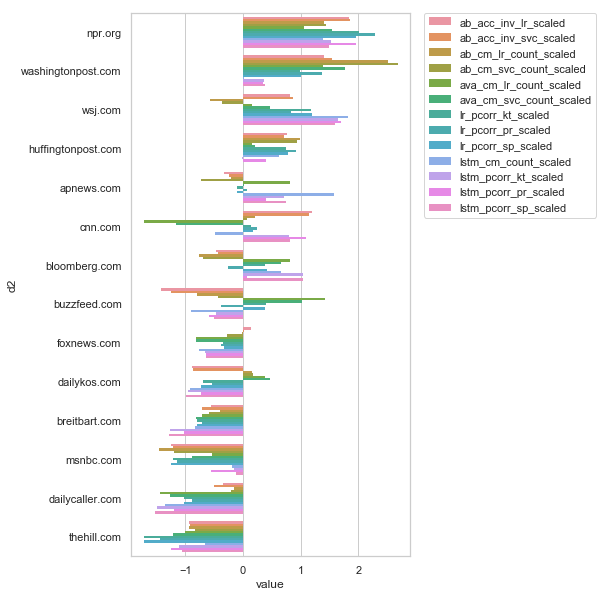

In [39]:
plot_domain_content('nytimes.com')

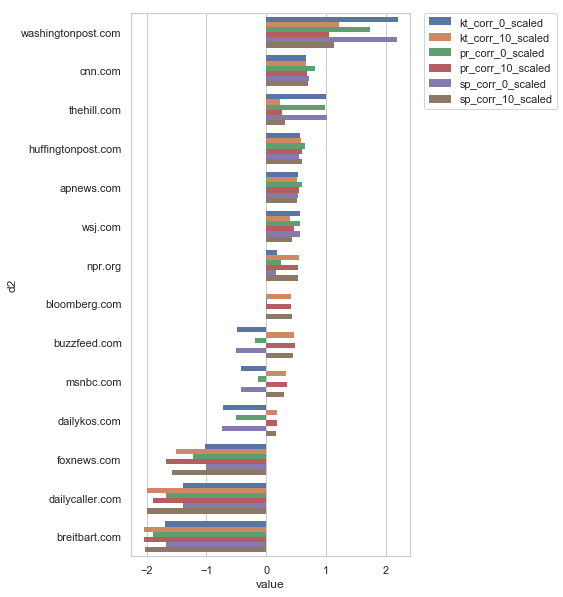

In [40]:
plot_domain_audience('nytimes.com')

In [41]:
def ca_corr(domain, c_metric, a_metric, plot=False):
    
    ddfc = dfc[dfc.d1==domain][['d2', c_metric]]
    ddfa = dfa[dfa.d1==domain][['d2', a_metric]]
    
    ddf = ddfc.merge(ddfa)
    
    if plot:
        ddf_melt = ddf.melt('d2', [c_metric, a_metric])
        order = ddf.sort_values(c_metric, ascending=False).d2
        plt.figure(figsize=(4,5))
        sns.barplot(y='d2', x='value', hue='variable', data=ddf_melt, order=order)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    return stats.pearsonr(ddf[c_metric], ddf[a_metric])

In [42]:
rows = []
for d, cm, am in tqdm(product(DOMAINS, DFC_METRICS, DFA_METRICS)):
    corr, p = ca_corr(d, cm, am)
    rows.append((d, cm, am, corr, p))

1170it [00:04, 241.35it/s]


In [43]:
corr_df = pd.DataFrame(rows, columns=('domain', 'cm', 'am', 'corr', 'p'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

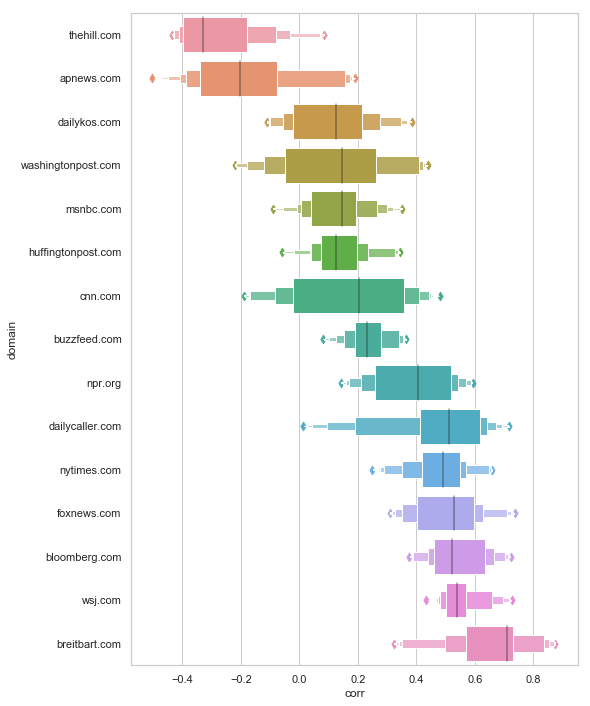

In [74]:
order = corr_df.groupby('domain').mean().sort_values('corr').index
plt.figure(figsize=(8,12))
sns.boxenplot(x='corr', y='domain', data=corr_df, order=order)

In [71]:
def plot_ac(domain):
    
    ddfc = dfc[dfc.d1==domain]
    ddfa = dfa[dfa.d1==domain]
    ddf = ddfc.merge(ddfa)
    
    pdf = ddf.melt(['d2'], C_METRICS+A_METRICS)
    pdf['metric_type'] = pdf['variable'].apply(lambda x: 'content' if x in C_METRICS else 'audience')
    
    order = pdf[pdf.metric_type=='content'].groupby('d2').mean().sort_values('value', ascending=False).index
    plt.figure(figsize=(5,5))
    sns.barplot(y='d2', x='value', hue='metric_type', data=pdf, order=order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

thehill.com


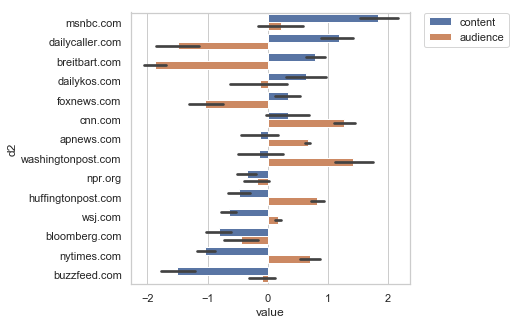

apnews.com


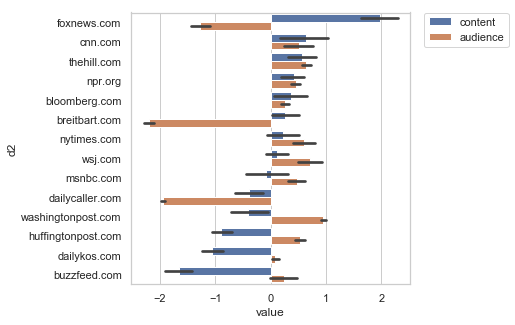

dailykos.com


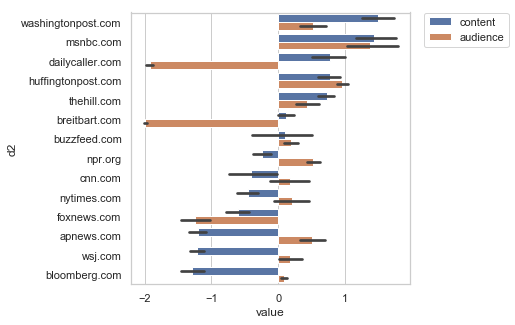

washingtonpost.com


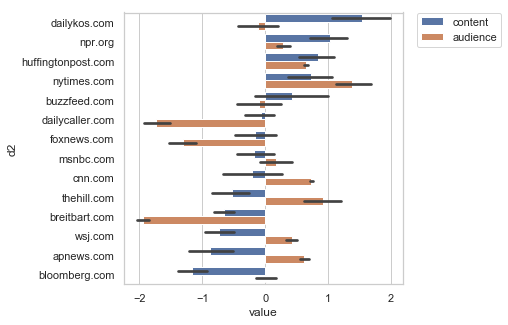

msnbc.com


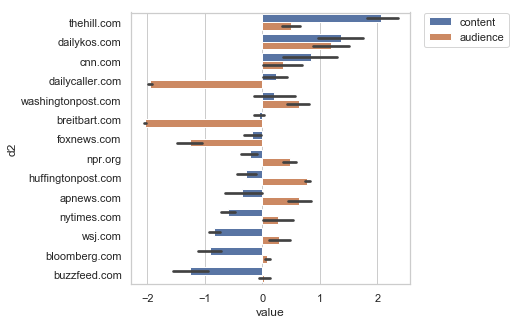

huffingtonpost.com


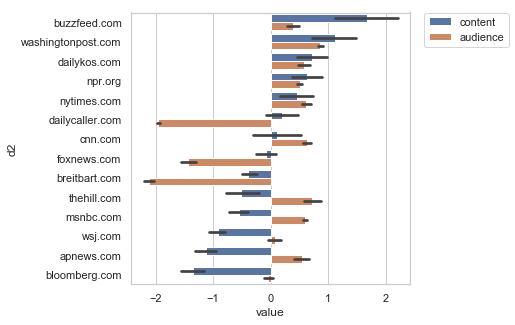

cnn.com


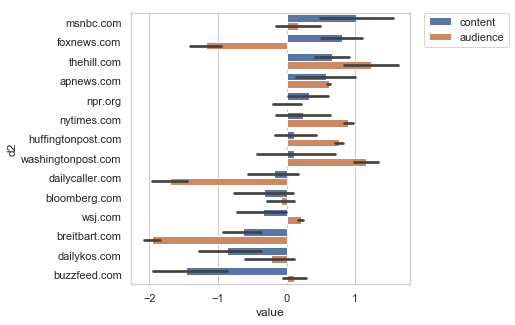

buzzfeed.com


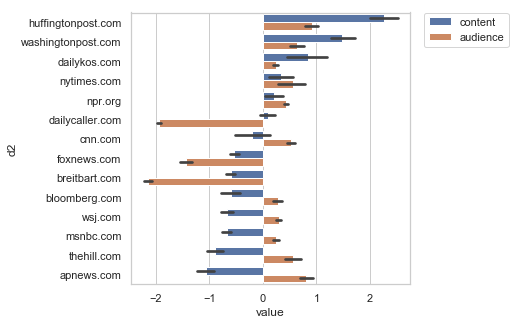

npr.org


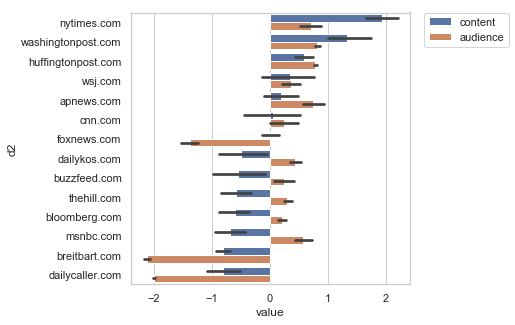

dailycaller.com


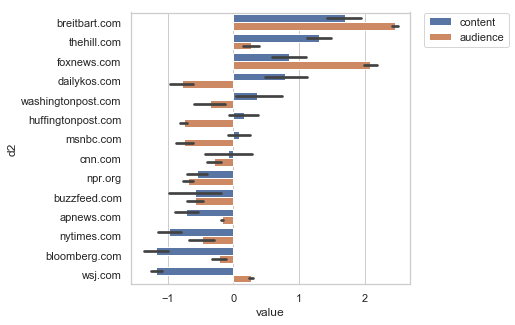

nytimes.com


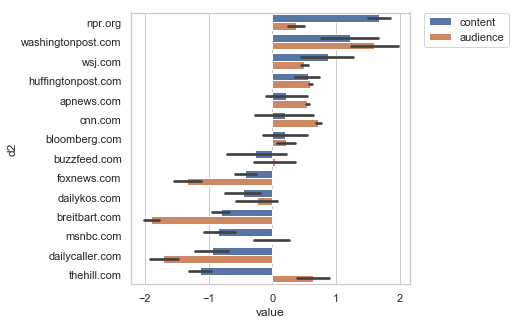

foxnews.com


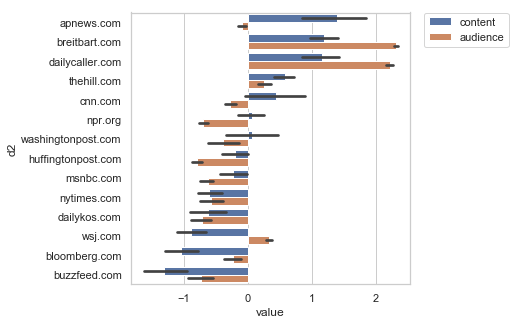

bloomberg.com


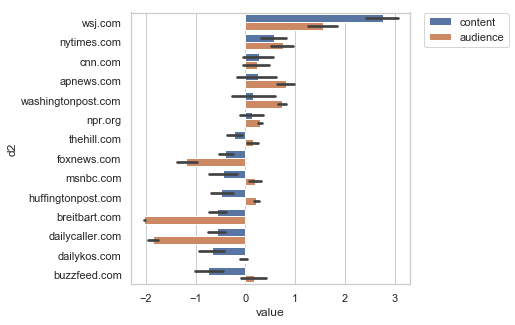

wsj.com


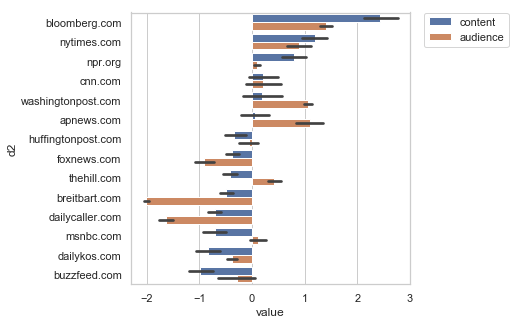

breitbart.com


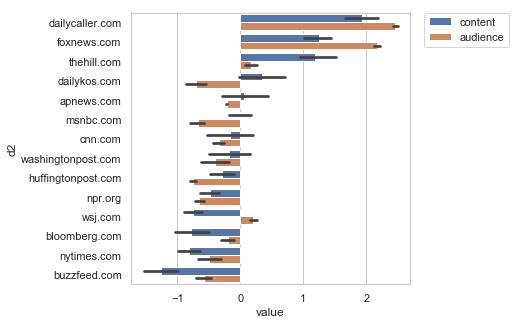

In [77]:
for d in order:
    print(d)
    plot_ac(d)

In [96]:
corr_df['mean_d'] = corr_df.groupby('domain')['corr'].transform(lambda x: abs(x - x.mean()))

In [98]:
corr_df.groupby(['cm', 'am']).mean().sort_values('mean_d').head(10)

corr         p    mean_d
cm                      am                                             
ab_acc_inv_svc_scaled   kt_corr_10_scaled  0.230341  0.402127  0.064863
                        sp_corr_10_scaled  0.232853  0.398979  0.065829
ava_cm_svc_count_scaled sp_corr_10_scaled  0.301677  0.267319  0.069460
lr_pcorr_sp_scaled      sp_corr_0_scaled   0.254110  0.343123  0.070760
ab_acc_inv_svc_scaled   pr_corr_10_scaled  0.212024  0.417183  0.071622
lr_pcorr_kt_scaled      sp_corr_0_scaled   0.255280  0.341073  0.071674
ava_cm_svc_count_scaled pr_corr_10_scaled  0.302671  0.270028  0.072108
lr_pcorr_sp_scaled      kt_corr_0_scaled   0.251522  0.344651  0.072739
lr_pcorr_kt_scaled      kt_corr_0_scaled   0.252808  0.343280  0.073032
ava_cm_svc_count_scaled pr_corr_0_scaled   0.251142  0.305936  0.073196

apnews.com


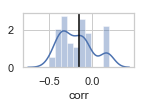

bloomberg.com


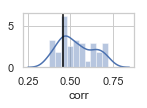

breitbart.com


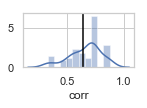

buzzfeed.com


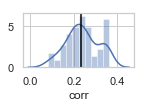

cnn.com


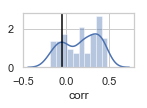

dailycaller.com


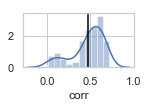

dailykos.com


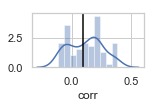

foxnews.com


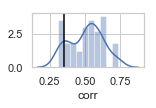

huffingtonpost.com


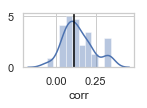

msnbc.com


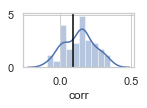

npr.org


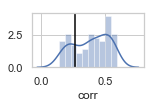

nytimes.com


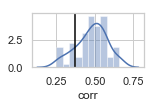

thehill.com


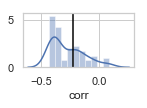

washingtonpost.com


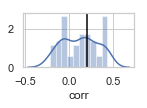

wsj.com


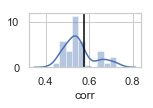

In [117]:
for d in corr_df.domain.unique():
    print(d)
    plt.figure(figsize=(2,1))
    sns.distplot(corr_df[corr_df.domain==d]['corr'], bins=10)
    corr = corr_df[(corr_df.domain==d)&(corr_df.cm=='ab_acc_inv_svc_scaled')&(corr_df.am=='kt_corr_10_scaled')].iloc[0]['corr']
    plt.axvline(corr, c='black')
    plt.show()